In [30]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from scipy.special import inv_boxcox
from sklearn.inspection import PartialDependenceDisplay

In [31]:
# import data and deserialize models & fitted_lambda to back transform box cox view rate
X_train = pd.read_csv("data/x_train.csv", index_col=0)
X_test = pd.read_csv("data/x_test.csv", index_col=0)
residuals = pd.read_csv("data/residuals.csv", index_col=0)
video_df = pd.read_csv("data/videos_prepared.csv")

with open("data/linreg.pkl", "rb") as f:
    linreg, lasso_cols = pickle.load(f)

with open("data/pipelines.pkl", "rb") as f:
    rf_pipeline, xgb_pipeline = pickle.load(f)

with open("data/fitted_lambda.pkl", "rb") as f:
    fitted_lambda = pickle.load(f)

X_test.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
288,0,20,0,11,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
778,0,14,2,7,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
355,1,17,6,2,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
481,1,18,5,9,0,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
607,0,19,3,4,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
# list the coefficients by highest absolute value for positive or negative impact on view count
coef_df = pd.Series(linreg.coef_, index=lasso_cols).sort_values(key=abs, ascending=False)
top_coef = coef_df.head(20)
top_coef

log_channel_view_count    0.979638
log_channel_sub_count     0.734646
term_vegangains           0.652126
term_truth                0.514153
cat_Education             0.486453
term_joeycarbstrong       0.474661
term_sub                  0.472499
log_duration_seconds     -0.464630
term_eat                  0.355459
term_omni                 0.354965
term_carnivore            0.306926
term_debate               0.305851
term_davidractivism      -0.305479
term_pubmed               0.301547
cat_Howto & Style         0.297717
term_protein              0.281452
term_socials              0.264586
term_supplements          0.259132
term_supporter            0.256585
term_join                -0.253986
dtype: float64

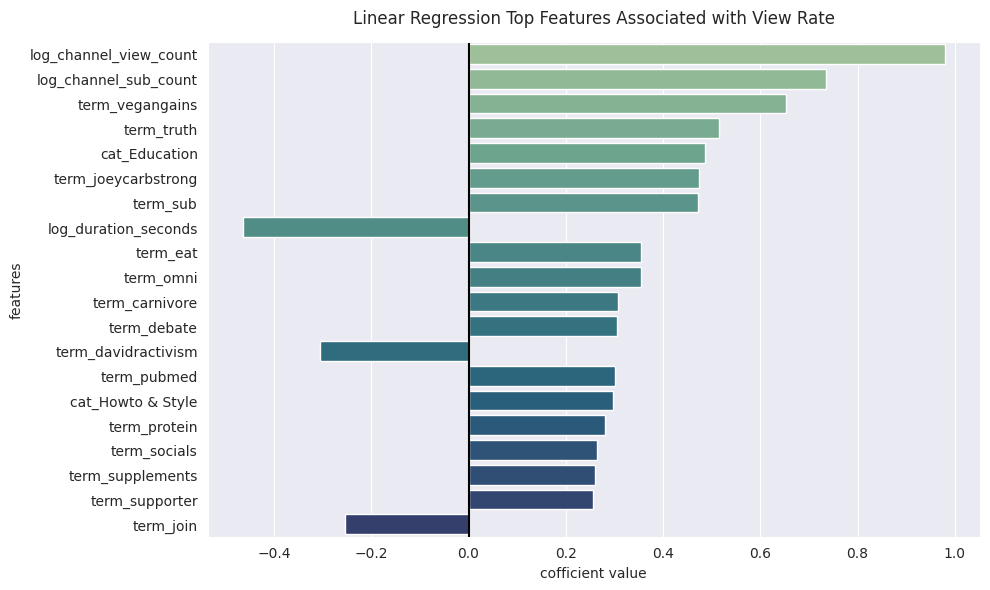

In [33]:
# visualize top feature coefficients
sns.set_style("darkgrid")
plt.subplots(figsize=(10, 6))
sns.barplot(x=top_coef.values, y=top_coef.index, palette="crest", hue=top_coef.index, legend=False, orient="h")
plt.axvline(0, color="black")
plt.title("Linear Regression Top Features Associated with View Rate", y=1.02)
plt.ylabel("features")
plt.xlabel("cofficient value")
plt.tight_layout()

# save png
plt.savefig("images/linreg_top_features.png", dpi=300)

In [34]:
# highest channel view count videos by highest video view rate
video_df["view_rate"] = round(inv_boxcox(video_df["box_view_rate"], fitted_lambda), 2)
video_df["channel_view_count"] = round(np.expm1(video_df["log_channel_view_count"]).astype("int"))
top_10_chan_view_count = video_df[["channel_title", "title", "channel_view_count", "view_rate"]].sort_values(["channel_view_count", "view_rate"], ascending=False).head(10)
top_10_chan_view_count

,channel_title,title,channel_view_count,view_rate
34,TEDx Talks,Every Argument Against Veganism | Ed Winters |...,8472012286,1037.77
715,TEDx Talks,A Plant-based Diet Changed My Life | Pat McAul...,8472012286,686.52
157,TEDx Talks,The Power of Plant-Based Eating | Dr. Joanne K...,8472012286,365.14
239,TEDx Talks,Why I'm A Vegan | Moby | TEDxVeniceBeach,8472012286,274.52
724,TEDx Talks,The Transformative Power of Raw Vegan Food | R...,8472012286,34.94
71,Brut India,Joaquin Phoenix On Why He's Vegan,3860424767,453.49
672,Brut India,Joaquin Phoenix's Powerful Speech on the Envir...,3860424767,10.79
297,Best Of TRS | English,Why Everyone Must Turn Vegetarian? Monk Explai...,928799385,1540.78
98,Big Think,Peter Singer: Animal suffering is human respon...,909607676,411.61
574,Fitshortie,What I Eat As A Long-Term Raw Vegan,854344432,1426.51


In [35]:
# highest subscriber count videos by highest video view rate
video_df["channel_sub_count"] = round(np.expm1(video_df["log_channel_sub_count"]).astype("int"))
top_10_sub_count = video_df[["channel_title", "title", "channel_sub_count", "view_rate"]].sort_values(["channel_sub_count", "view_rate"], ascending=False).head(10)
top_10_sub_count

,channel_title,title,channel_sub_count,view_rate
34,TEDx Talks,Every Argument Against Veganism | Ed Winters |...,43200000,1037.77
715,TEDx Talks,A Plant-based Diet Changed My Life | Pat McAul...,43200000,686.52
157,TEDx Talks,The Power of Plant-Based Eating | Dr. Joanne K...,43200000,365.14
239,TEDx Talks,Why I'm A Vegan | Moby | TEDxVeniceBeach,43200000,274.52
724,TEDx Talks,The Transformative Power of Raw Vegan Food | R...,43200000,34.94
98,Big Think,Peter Singer: Animal suffering is human respon...,7990000,411.61
71,Brut India,Joaquin Phoenix On Why He's Vegan,4509999,453.49
672,Brut India,Joaquin Phoenix's Powerful Speech on the Envir...,4509999,10.79
311,Acharya Prashant,"Sir, how did you turn vegan? || Acharya Prashant",2810000,309.54
171,OxfordUnion,Joey Carbstrong argues that animals are sentie...,2310000,110.60


In [36]:
# highest vegan gains view rate
top_10_vegangains = video_df[["channel_title", "title", "term_vegangains", "view_rate"]][video_df["term_vegangains"] > 0].sort_values(["view_rate"], ascending=False).head(10)
top_10_vegangains

,channel_title,title,term_vegangains,view_rate
791,Turkey Tom,YouTube's Most Psychotic Vegan,0.147948,2816.10
49,Vegan Gains,This Isn't Even My Final Form - Dieting and Ma...,0.632997,1497.63
383,Vegan Gains,"Back and Biceps, Getting Shredded - Final Form...",0.639709,1477.71
632,Vegan Gains,Lower Body Training - Final Form Day 3,0.581135,835.10
70,Last Night On Destiny,Destiny Gets Into Screaming Match w/ VeganGain...,0.553985,728.73
175,Vegan Gains,How I Cured My Depression,0.663555,549.23
809,Destiny,"""Why Do You Do This?"" Destiny Debates Vegan Gains",0.273277,274.22
677,VincePotato,Vegan Gains Comments On Marriage/Divorce With ...,0.428215,152.95
441,Vegan Gains,Dr. Todd Lee vs. Vegan Gains - Live Discussion...,0.563125,152.81
685,Vegan Gains,Dr. Greger vs Vegan Gains Debate Erythritol Sa...,0.583529,118.14


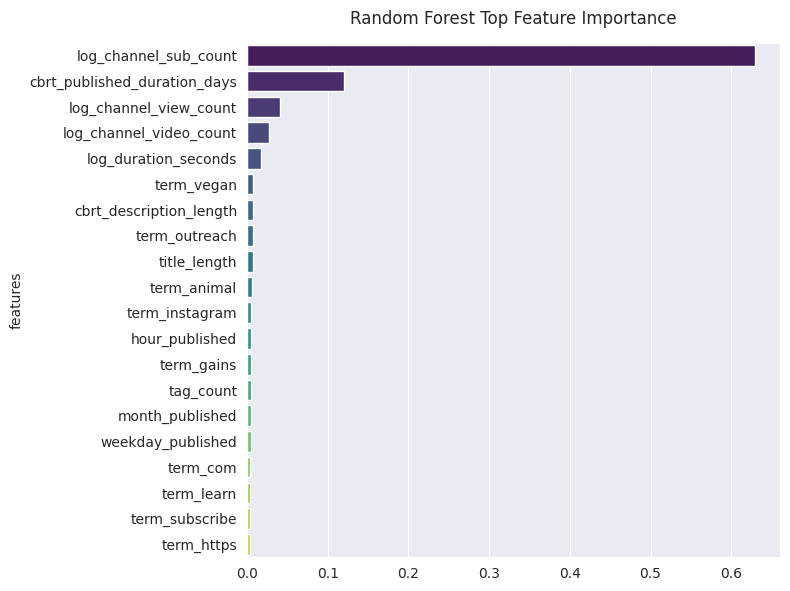

In [37]:
# visualize rf top 20 important features
rf_feature_importances = pd.Series(rf_pipeline["randomforestregressor"].feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = rf_feature_importances.head(20)

plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("Random Forest Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/rf_top_feature_importance.png", dpi=300)

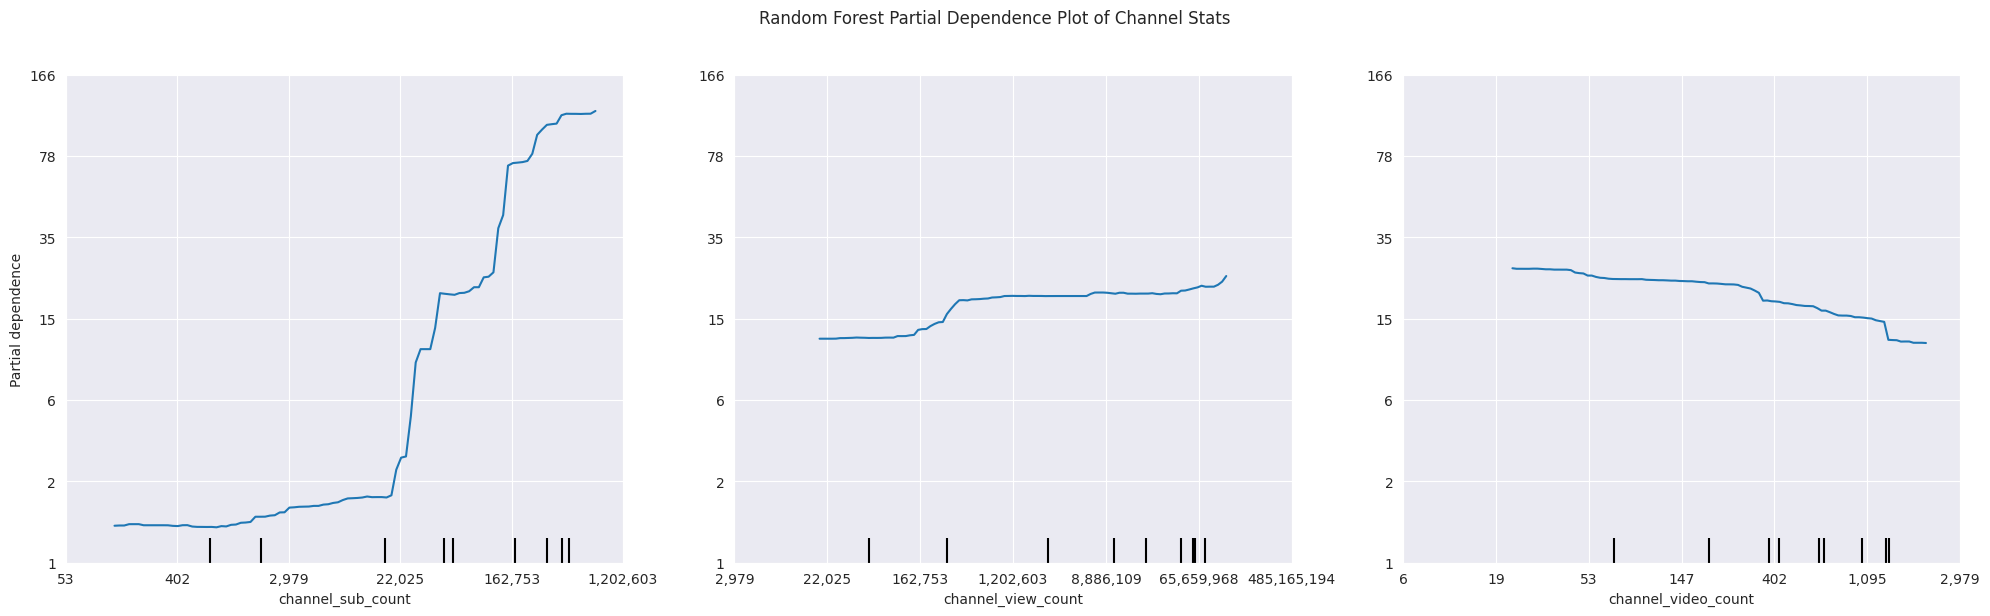

In [38]:
# visualize rf partial dependence for channel stats
fig, ax = plt.subplots(figsize=(20, 6))
display = PartialDependenceDisplay.from_estimator(estimator=rf_pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_view_count", "log_channel_video_count"], ax=ax, grid_resolution=100)
original_features = ["channel_sub_count", "channel_view_count", "channel_video_count"]

for axis, feature in zip(display.axes_.ravel(), original_features):
    xlabels = axis.get_xticks()
    axis.set_xticks(xlabels)
    axis.set_xticklabels([f"{int(np.expm1(x)):,}" for x in xlabels])
    axis.set_xlabel(feature)
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{int(inv_boxcox(y, fitted_lambda)):,}" for y in ylabels])

display, original_features
fig.suptitle("Random Forest Partial Dependence Plot of Channel Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/rf_pdp_channel_stats.png", dpi=300)

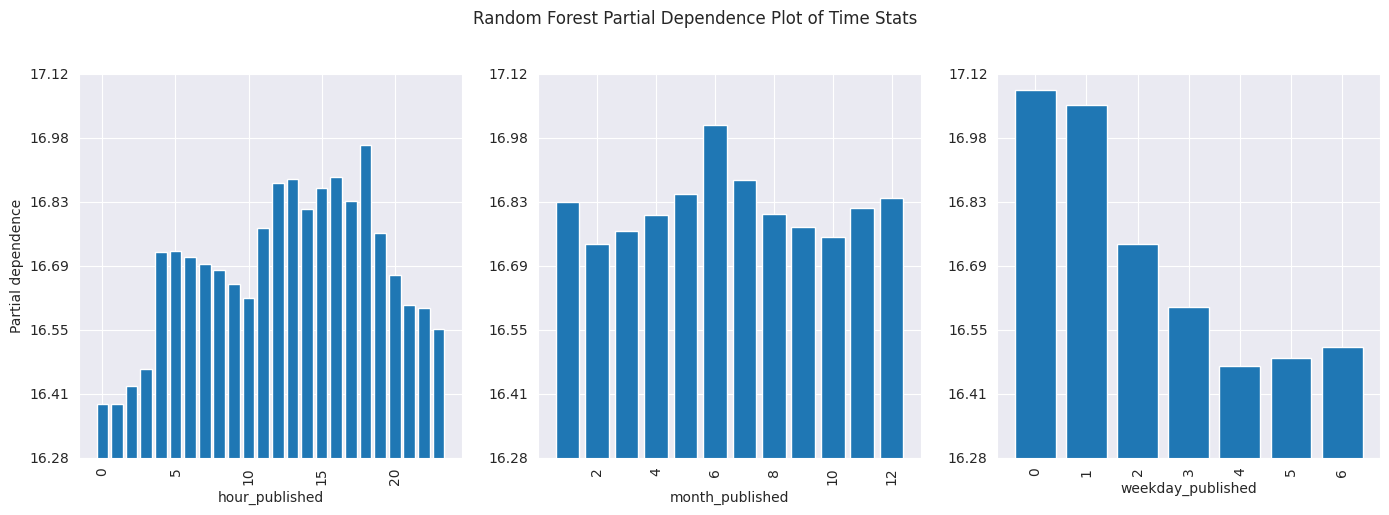

In [39]:
# visualize rf partial dependence time stats
fig, ax = plt.subplots(figsize=(14, 5))
display = PartialDependenceDisplay.from_estimator(estimator=rf_pipeline, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)

for axis in display.axes_.ravel():
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{round(inv_boxcox(y, fitted_lambda), 2)}" for y in ylabels])

fig.suptitle("Random Forest Partial Dependence Plot of Time Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/rf_pdp_time_stats.png", dpi=300)

/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


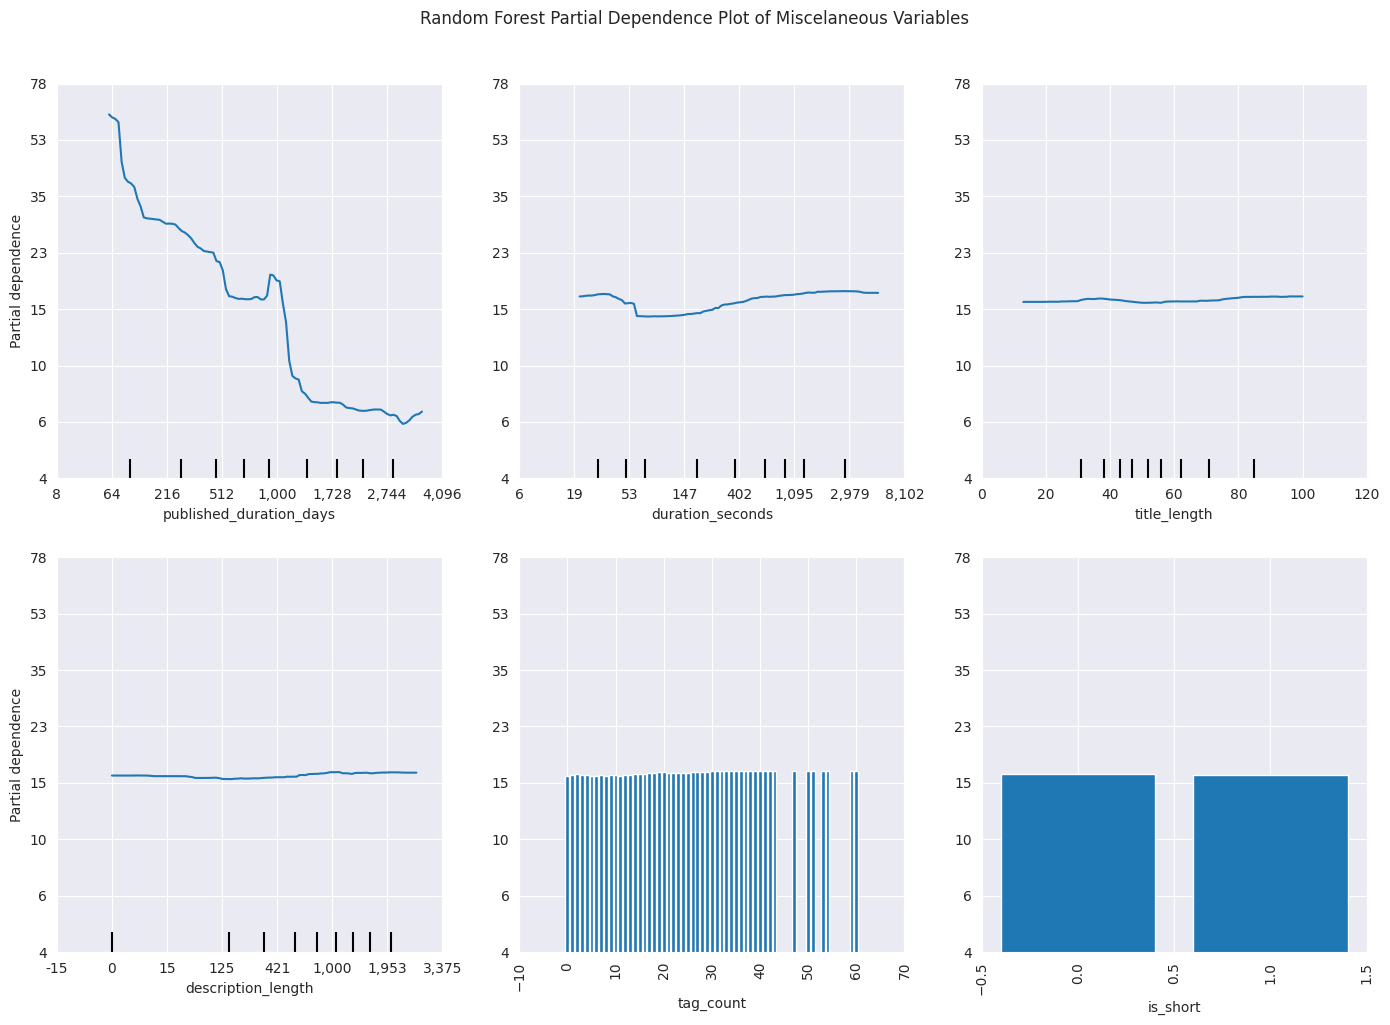

In [40]:
# visualize rf partial dependence miscelaneous variables
fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(estimator=rf_pipeline, X=X_train, features=["cbrt_published_duration_days", "log_duration_seconds", "title_length", "cbrt_description_length", "tag_count", "is_short"], categorical_features=["tag_count", "is_short"], ax=ax, grid_resolution=100)
original_features = ["published_duration_days", "duration_seconds", "title_length", "description_length", "tag_count", "is_short"]

for axis, feature in zip(display.axes_.ravel(), original_features):
    xlabels = axis.get_xticks()
    axis.set_xticks(xlabels)
    if feature == "duration_seconds":
        axis.set_xticklabels([f"{int(np.expm1(x)):,}" for x in xlabels])
    elif feature == "published_duration_days" or feature == "description_length":
        axis.set_xticklabels([f"{int(x**3):,}" for x in xlabels])
    axis.set_xlabel(feature)
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{int(inv_boxcox(y, fitted_lambda)):,}" for y in ylabels])
    
fig.suptitle("Random Forest Partial Dependence Plot of Miscelaneous Variables", y=1.02)
plt.tight_layout()

# save fig
plt.savefig("images/rf_pdp_misc_variables.png", dpi=300)

In [41]:
# get the shap values of each feature
scaler = rf_pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
explainer = shap.TreeExplainer(rf_pipeline["randomforestregressor"])
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,-0.003465,0.045373,0.030971,0.005629,0.000589,0.022804,0.004040,-0.015285,0.001416,0.000058,...,0.0,-0.000074,-0.000298,-0.000037,0.002844,0.009143,0.001443,0.000076,0.0,0.0
1,-0.006024,-0.011805,0.053287,-0.022137,-0.000647,0.002949,-0.000768,0.000162,0.000311,0.000119,...,0.0,-0.000335,-0.000054,-0.003519,0.005523,0.001274,0.001864,-0.000008,0.0,0.0
2,0.037255,0.011420,0.003218,0.000906,0.000803,0.003967,-0.001437,-0.002552,0.000518,0.001252,...,0.0,-0.000111,-0.000078,0.000807,0.000997,0.001367,0.000506,0.000019,0.0,0.0
3,-0.004690,0.000369,-0.030775,0.012586,0.001644,0.002240,-0.001721,0.007493,0.000867,0.000060,...,0.0,-0.000191,-0.000052,0.000112,0.003571,-0.002908,0.001628,-0.000008,0.0,0.0
4,-0.002796,0.002739,-0.036088,-0.030476,-0.005149,0.002803,-0.000589,-0.002035,-0.000228,0.000115,...,0.0,-0.000078,-0.000124,-0.000009,-0.001608,0.010010,0.006815,-0.000011,0.0,0.0


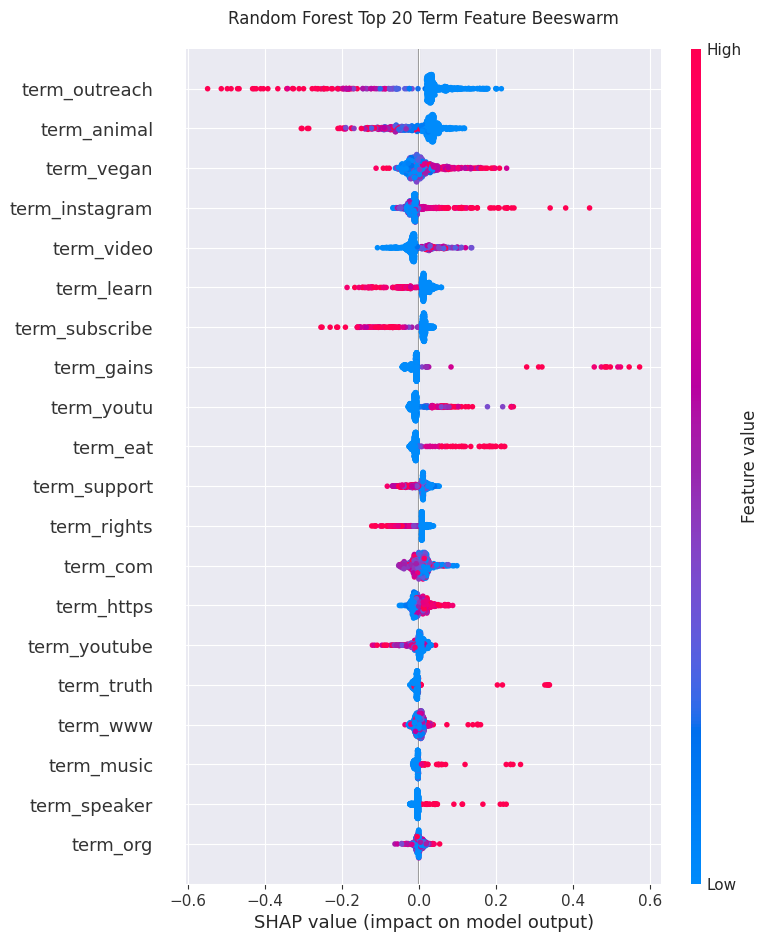

In [42]:
# visualize beeswarm of top 20 term features
terms = []
for col in rf_feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]

plt.title("Random Forest Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot", show=False)

# save png
plt.savefig("images/rf_term_beeswarm.png", dpi=300)

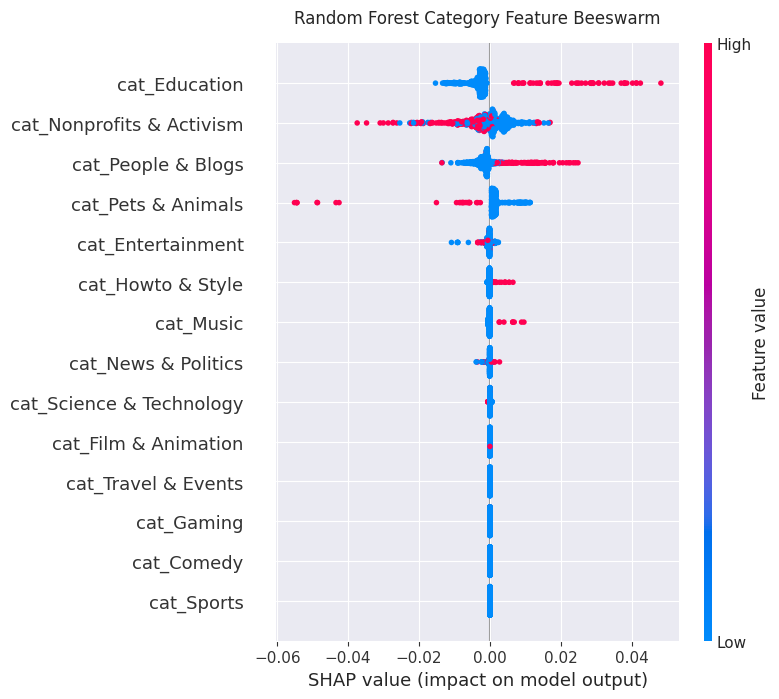

In [43]:
# visualize beeswarm of category features
categories = []
for col in rf_feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)

plt.title("Random Forest Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot", show=False)
plt.tight_layout()

# save png
plt.savefig("images/rf_category_beeswarm.png", dpi=300)

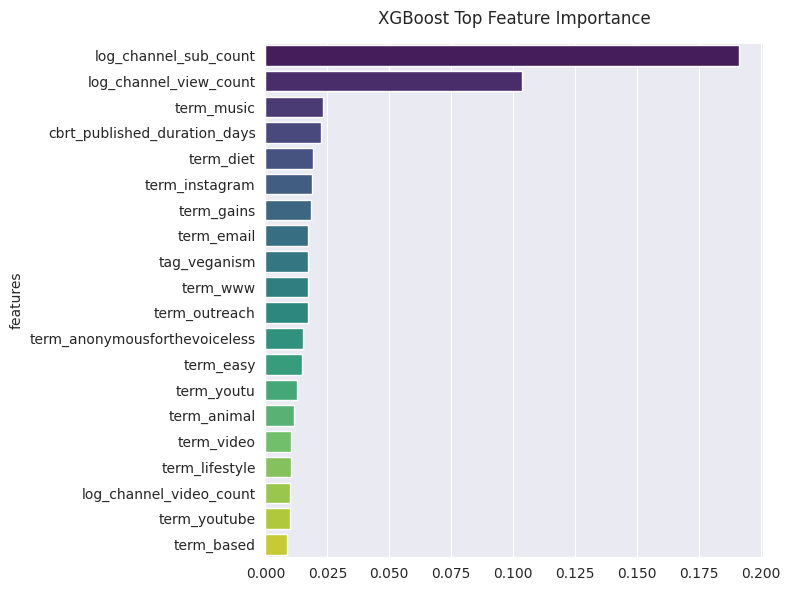

In [44]:
# visualize xgb top 20 important features
feature_importances = pd.Series(xgb_pipeline["xgbregressor"].feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)

plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("XGBoost Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/xgb_top_feature_importance.png", dpi=300)

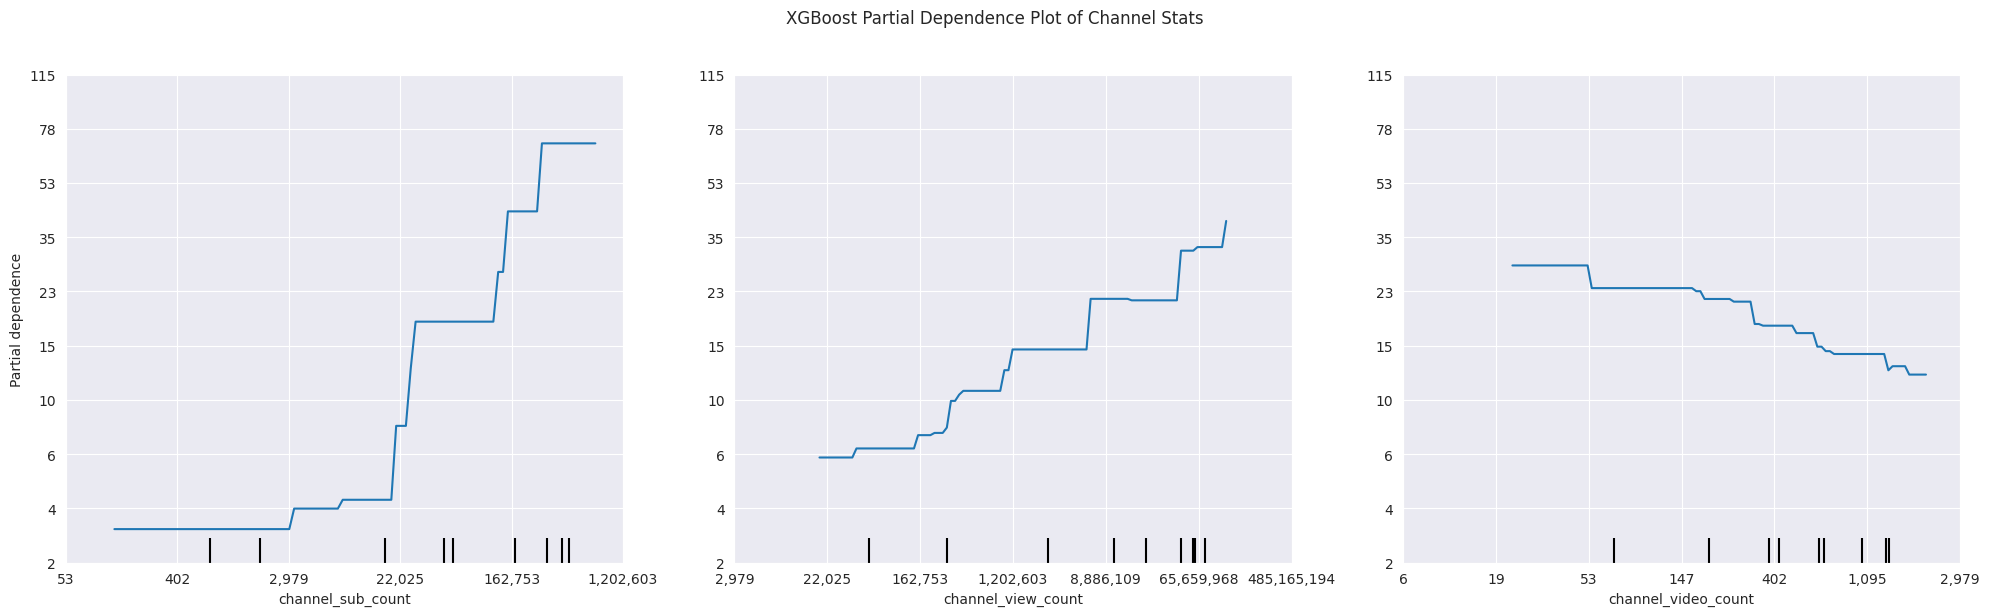

In [45]:
# visualize xgb partial dependence for channel stats
fig, ax = plt.subplots(figsize=(20, 6))
display = PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_view_count", "log_channel_video_count"], ax=ax, grid_resolution=100)
original_features = ["channel_sub_count", "channel_view_count", "channel_video_count"]

for axis, feature in zip(display.axes_.ravel(), original_features):
    xlabels = axis.get_xticks()
    axis.set_xticks(xlabels)
    axis.set_xticklabels([f"{int(np.expm1(x)):,}" for x in xlabels])
    axis.set_xlabel(feature)
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{int(inv_boxcox(y, fitted_lambda)):,}" for y in ylabels])

display, original_features
fig.suptitle("XGBoost Partial Dependence Plot of Channel Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/xgb_pdp_channel_stats.png", dpi=300)

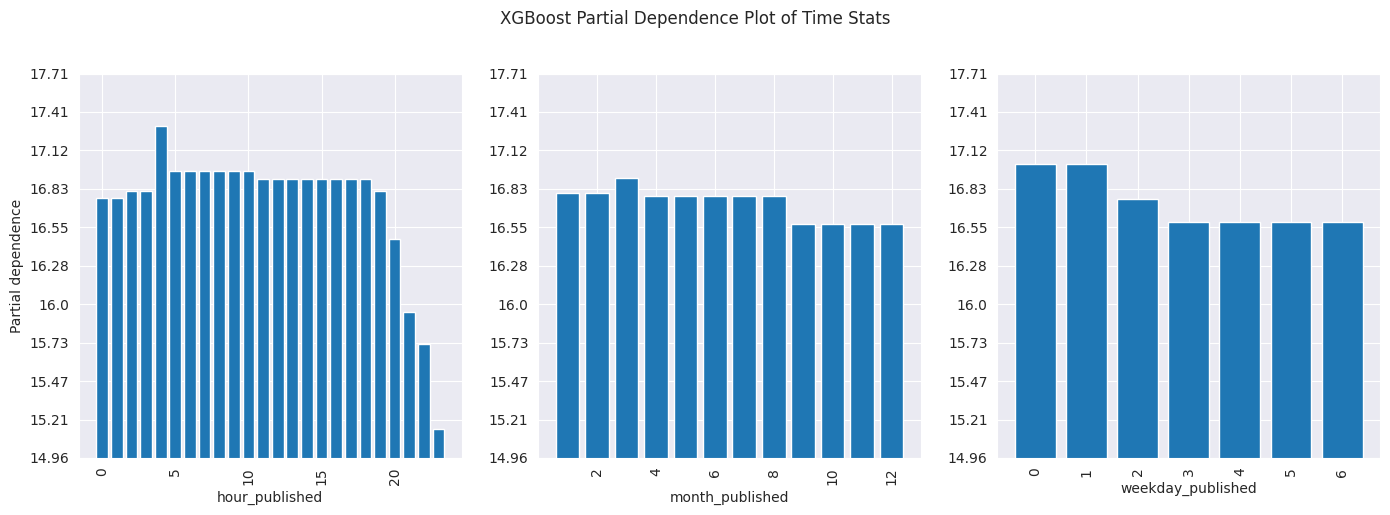

In [46]:
# visualize xgb partial dependence time stats
fig, ax = plt.subplots(figsize=(14, 5))
display = PartialDependenceDisplay.from_estimator(estimator=xgb_pipeline, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)

for axis in display.axes_.ravel():
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{round(inv_boxcox(y, fitted_lambda), 2)}" for y in ylabels])

fig.suptitle("XGBoost Partial Dependence Plot of Time Stats", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/xgb_pdp_time_stats.png", dpi=300)

/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


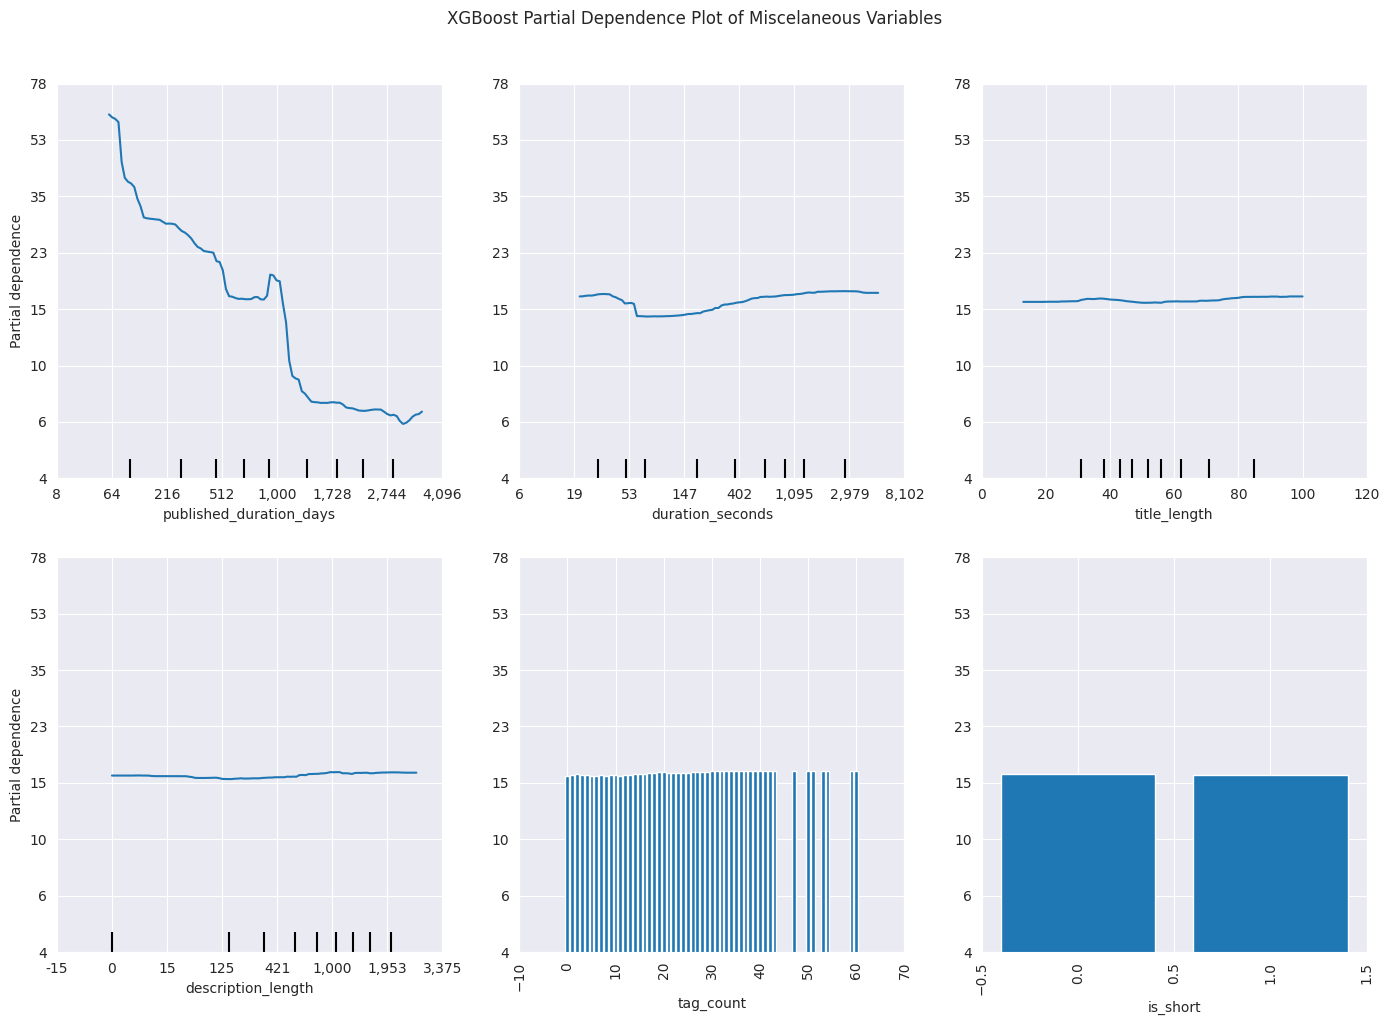

In [47]:
# visualize xgb partial dependence miscelaneous variables
fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(estimator=rf_pipeline, X=X_train, features=["cbrt_published_duration_days", "log_duration_seconds", "title_length", "cbrt_description_length", "tag_count", "is_short"], categorical_features=["tag_count", "is_short"], ax=ax, grid_resolution=100)
original_features = ["published_duration_days", "duration_seconds", "title_length", "description_length", "tag_count", "is_short"]

for axis, feature in zip(display.axes_.ravel(), original_features):
    xlabels = axis.get_xticks()
    axis.set_xticks(xlabels)
    if feature == "duration_seconds":
        axis.set_xticklabels([f"{int(np.expm1(x)):,}" for x in xlabels])
    elif feature == "published_duration_days" or feature == "description_length":
        axis.set_xticklabels([f"{int(x**3):,}" for x in xlabels])
    axis.set_xlabel(feature)
    ylabels = axis.get_yticks()
    axis.set_yticks(ylabels)
    axis.set_yticklabels([f"{int(inv_boxcox(y, fitted_lambda)):,}" for y in ylabels])
    
fig.suptitle("XGBoost Partial Dependence Plot of Miscelaneous Variables", y=1.02)
plt.tight_layout()

# save fig
plt.savefig("images/xgb_pdp_misc_variables.png", dpi=300)

In [48]:
# get the shap values of each feature
explainer = shap.TreeExplainer(xgb_pipeline["xgbregressor"])
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,-0.004934,0.018804,0.011124,-0.004225,0.0,0.004504,0.0,0.007585,0.001608,-0.000811,...,0.0,0.0,0.0,0.0,-0.002096,0.0,0.0,0.0,0.0,0.0
1,-0.007409,0.010896,0.021458,-0.005484,0.0,0.004504,0.0,0.003980,0.000628,-0.001060,...,0.0,0.0,0.0,0.0,0.021063,0.0,0.0,0.0,0.0,0.0
2,0.074962,0.041763,-0.004823,0.000737,0.0,0.004504,0.0,0.003980,0.000628,-0.000389,...,0.0,0.0,0.0,0.0,-0.000061,0.0,0.0,0.0,0.0,0.0
3,-0.015230,0.000624,-0.013155,0.001049,0.0,0.004504,0.0,-0.038158,0.000628,-0.003349,...,0.0,0.0,0.0,0.0,-0.001333,0.0,0.0,0.0,0.0,0.0
4,-0.007292,-0.001739,-0.056224,0.012264,0.0,0.001985,0.0,0.001452,0.000628,-0.025912,...,0.0,0.0,0.0,0.0,-0.000553,0.0,0.0,0.0,0.0,0.0


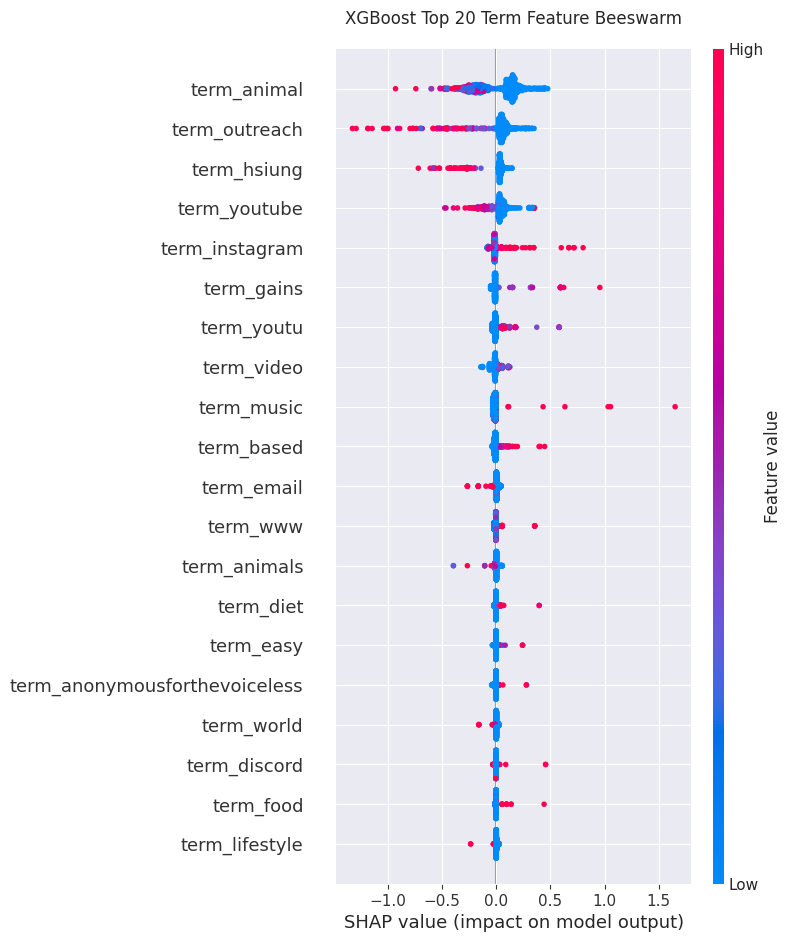

In [49]:
# visualize beeswarm of top 20 term features
terms = []
for col in feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]


plt.title("XGBoost Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot", show=False)

# save png
plt.savefig("images/xgb_term_beeswarm.png", dpi=300)

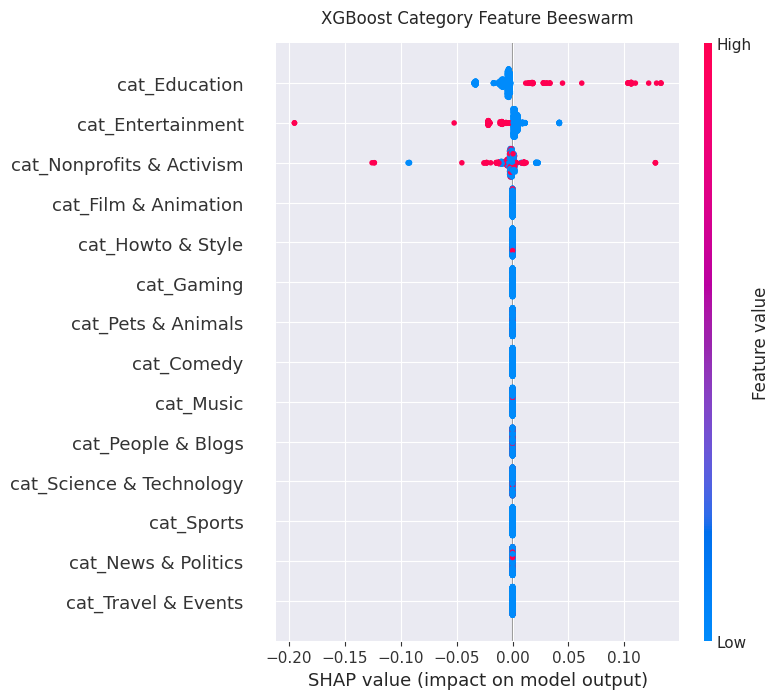

In [50]:
# visualize beeswarm of category features
categories = []
for col in feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)

plt.title("XGBoost Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot", show=False)
plt.tight_layout()

# save png
plt.savefig("images/xgb_category_beeswarm.png", dpi=300)

In [33]:
# convert box cox residuals to original in video view rate and label with video and channel title
labels = pd.read_csv("data/videos_prepared.csv", usecols=[0, 1, 2, 322])
labled_residuals = pd.merge(labels, residuals, left_index=True, right_index=True).rename(columns={"box_view_rate_x": "box_view_rate", "box_view_rate_y": "original_residual"})
labled_residuals["original_view_rate"] = inv_boxcox(labled_residuals["box_view_rate"], fitted_lambda)
labled_residuals["original_predicted"] = labled_residuals["original_view_rate"] - labled_residuals["original_residual"]
labled_residuals = labled_residuals.iloc[:, [0,1,2,3,5,6,4]].sort_values("original_residual", key=abs, ascending=False)
labled_residuals.head(10)

,video_id,title,channel_title,box_view_rate,original_view_rate,original_predicted,original_residual
616,0VHK8wpFci4,The breakfast that helped me lose 40lbs as a v...,Chelsea Mae,11.432530,5893.115880,329.501019,5563.614861
224,H0AvSe2pqr8,I left secret cameras in a HALAL Slaughterhous...,Joey Carbstrong,10.138474,2696.172414,350.201160,2345.971254
464,bi1cfkksehM,Think From The Victim's Perspective #vegan #an...,Arvind Animal Activist,9.341647,1634.248227,313.889243,1320.358984
81,w81NRCt6Z2I,BREAKING: WORLD-FIRST EXPOSÉ | HUGE EGG HEN GA...,Joey Carbstrong,9.805899,2191.800000,915.812944,1275.987056
649,2Uut8vNBfdk,Dietitian Answers Commonly Asked Questions Abo...,Goodful,8.561347,985.804666,137.368563,848.436103
17,G5o4ym5in_w,A Masterclass On Plant-Based Nutrition | Rich ...,Rich Roll,8.769700,1129.981013,295.139890,834.841123
225,JXv4NiWO2F0,‘Wellness’ is destroying veganism. Here’s why.,Earthling Ed,9.596302,1921.000000,1163.557131,757.442869
279,0MZXAHmo6eE,Here’s How To Build Muscle Mass On A Vegan Diet,Korin Sutton,7.899907,634.269780,18.132387,616.137393
96,h3TBH9m7aVM,Pigeon kicking punk instantly regrets it (lear...,Joey Carbstrong,8.330592,846.365385,404.217575,442.147810
272,2VJM7Ix1jjU,I Set a Vegan Trap for this Meat Eater...,Joey Carbstrong,7.558675,502.838710,902.409638,-399.570928


In [5]:
# scale test features and get shap values
explainer = shap.TreeExplainer(rf)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
shap_values = pd.DataFrame(explainer.shap_values(X_test_scaled), columns=X_test.columns, index=X_test.index)
shap_values.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
757,-0.005394,0.000320,-0.009045,0.011690,-0.000120,-0.000013,-0.001247,0.000451,0.000103,0.0,...,0.000676,0.002198,0.002761,-0.005328,0.002663,-0.157867,1.581936,0.859544,0.024773,0.002061
607,-0.009496,0.033507,0.007634,-0.003533,0.001616,-0.000008,-0.002338,0.000513,0.000016,0.0,...,-0.008274,0.000851,0.000573,-0.002981,-0.004840,0.153976,-2.098026,0.280857,0.058820,0.022059
362,-0.012211,0.085734,0.008928,-0.013381,0.005862,-0.000011,-0.001850,-0.000051,-0.000004,0.0,...,0.002204,0.000823,-0.000438,-0.004737,-0.005154,0.441973,-1.610093,-0.324115,0.025135,0.015037
629,-0.004482,0.086421,-0.001576,0.002481,-0.003525,-0.000017,-0.003012,0.000409,0.000101,0.0,...,-0.014416,0.000978,0.001985,-0.002682,-0.002215,-0.104798,-2.498394,0.521236,0.006974,-0.048251
852,-0.003906,0.013462,0.002045,-0.001654,-0.000107,-0.000012,-0.000894,-0.001266,-0.000226,0.0,...,-0.018191,0.001836,0.002147,-0.009356,0.005892,-0.134633,1.260326,0.158910,-0.001365,0.004774


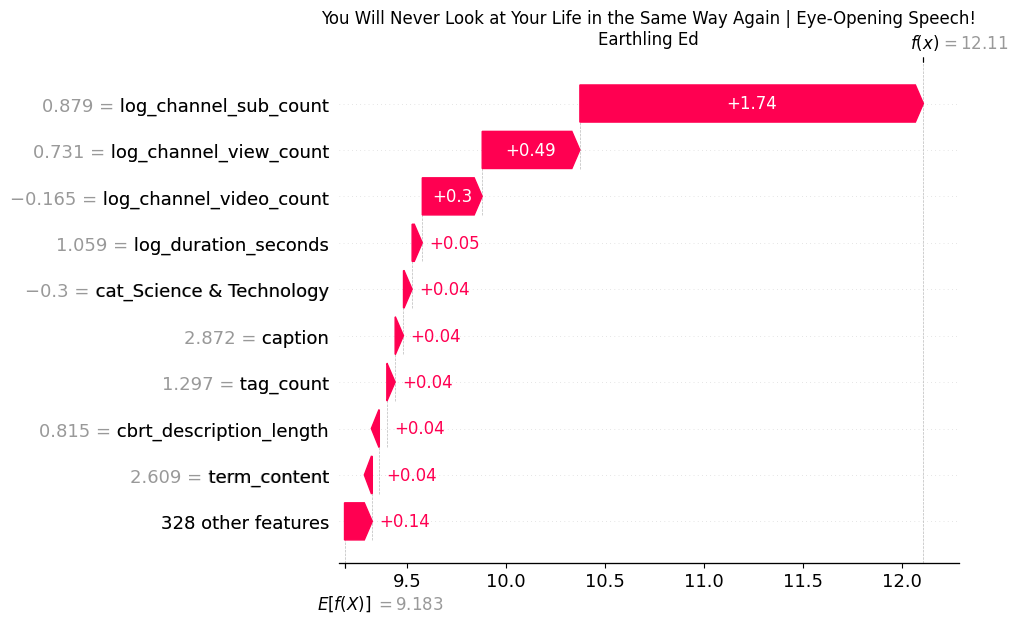

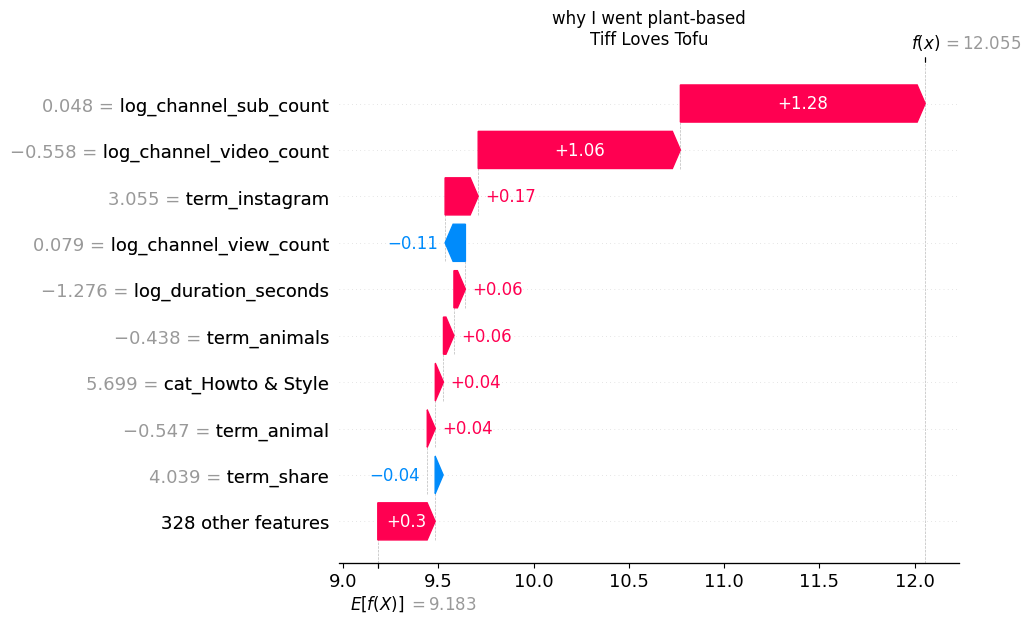

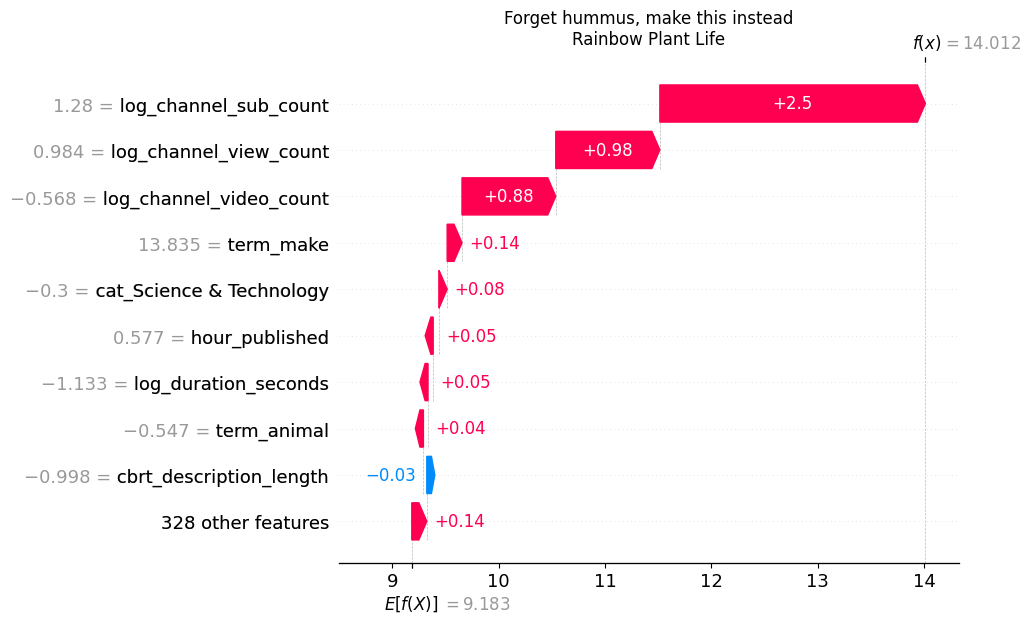

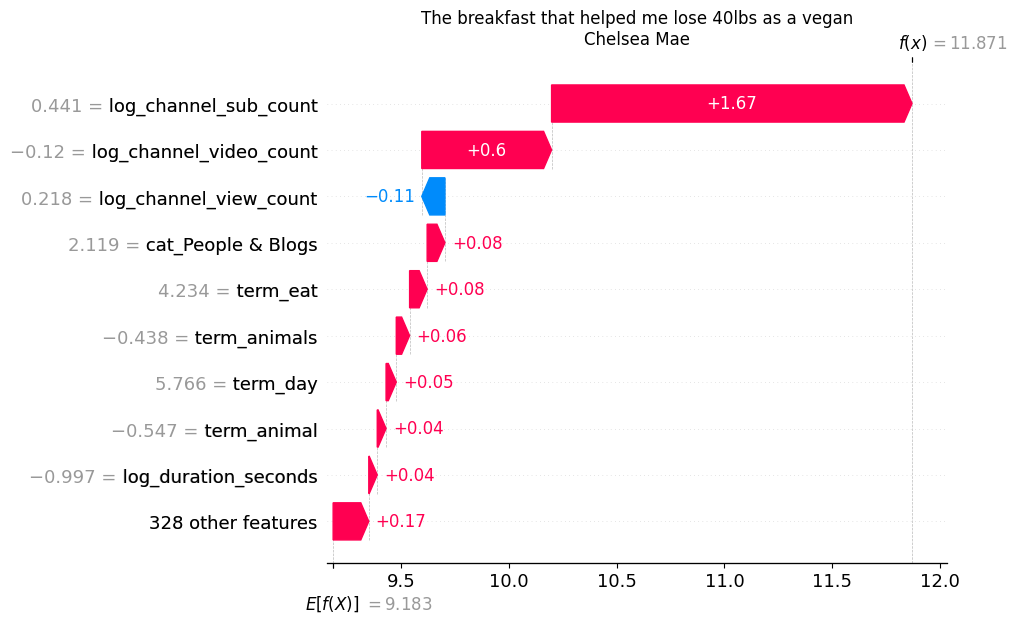

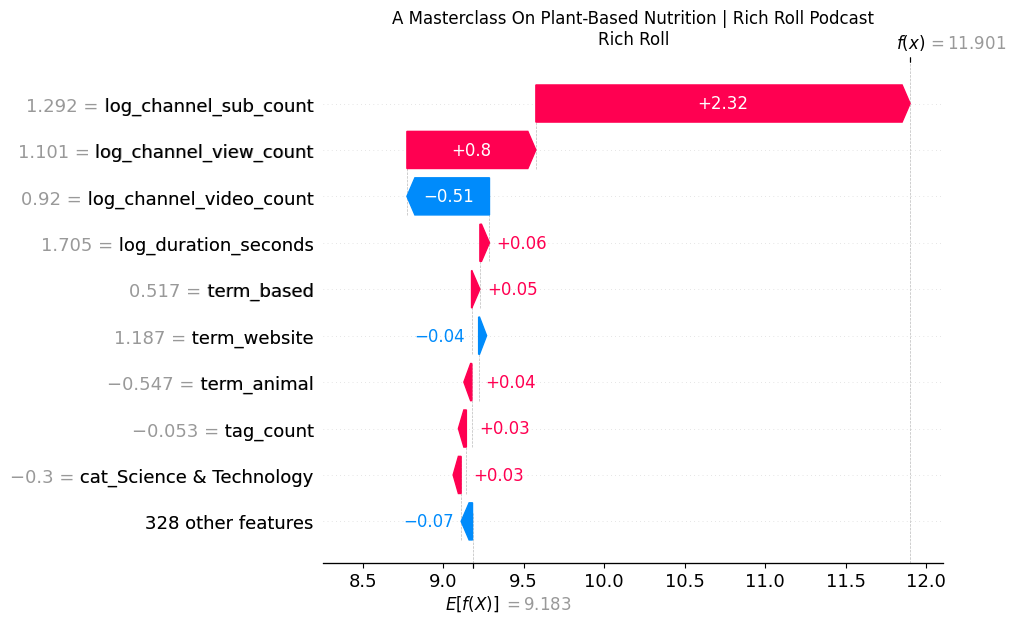

In [6]:
# visualize local shap for top 5 residuals
for i in labled_residuals.index[:5]:
    plt.title(f"{labled_residuals.loc[i]["title"]}\n{labled_residuals.loc[i]["channel_title"]}", y=1.02)
    shap.waterfall_plot(shap.Explanation(values=shap_values.loc[i].values, base_values=explainer.expected_value, data=X_test_scaled.loc[i].values, feature_names=X_test_scaled.columns), show=False)
    file = ("_").join(labled_residuals.loc[i]["channel_title"].lower().split(" "))

    # save png
    plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [7]:
# sort residuals by most over predicted
labled_residuals_negative = labled_residuals.sort_values("act_residual").head()
labled_residuals_negative

,video_id,title,channel_title,log_view_count,log_predicted,log_residual,act_view_count,act_predicted,act_residual
460,HoPGzB0NMuA,Major Update! #vegan #animals #update #speaker...,Arvind Animal Activist,10.458120,12.690944,-2.232824,34825.0,324792.09,-289967.09
702,H4Y_icXdpV8,The Reality of Meat #truth #motivation #vegan ...,Arvind Animal Activist,10.435996,12.539477,-2.103481,34063.0,279141.32,-245078.32
354,STWUAUFsyKQ,"Why Eat ""Mock Meat""? #truth #motivation #vegan...",Arvind Animal Activist,10.819978,12.587756,-1.767778,50009.0,292948.66,-242939.66
389,Uw2FbUawACQ,What I Eat In A Day as a vegan food blogger! 🌮...,Carleigh Bodrug,13.436627,13.654472,-0.217845,684624.0,851258.14,-166634.14
524,Ud2UfUHZm4w,"Healthline: ""Detrimental"" Vitamin A Deficiency...",Mic the Vegan,11.182572,12.319382,-1.136809,71866.0,223994.60,-152128.60


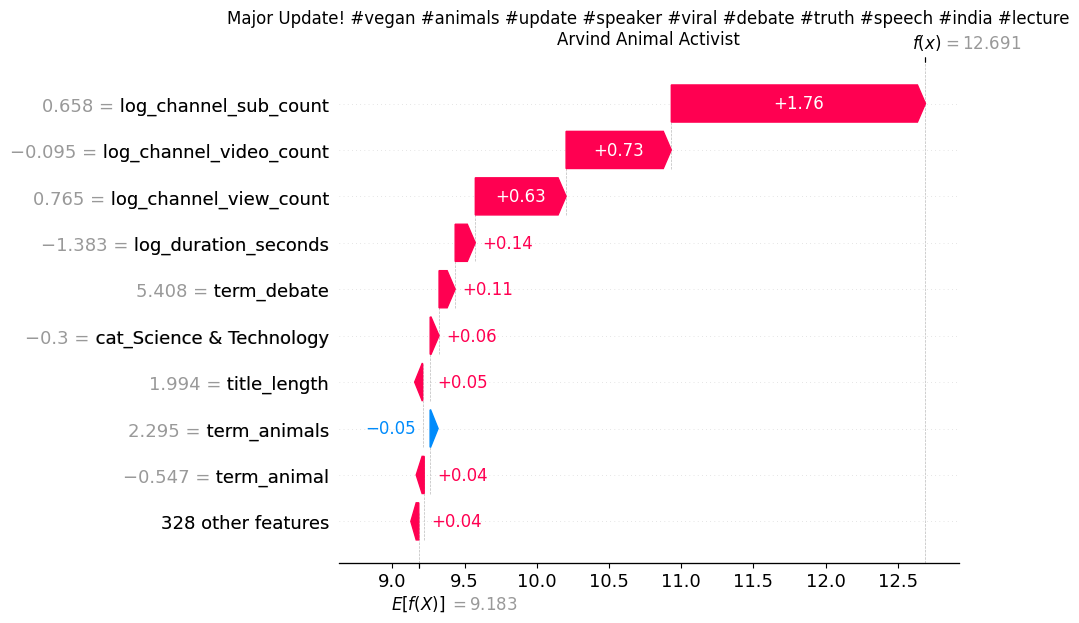

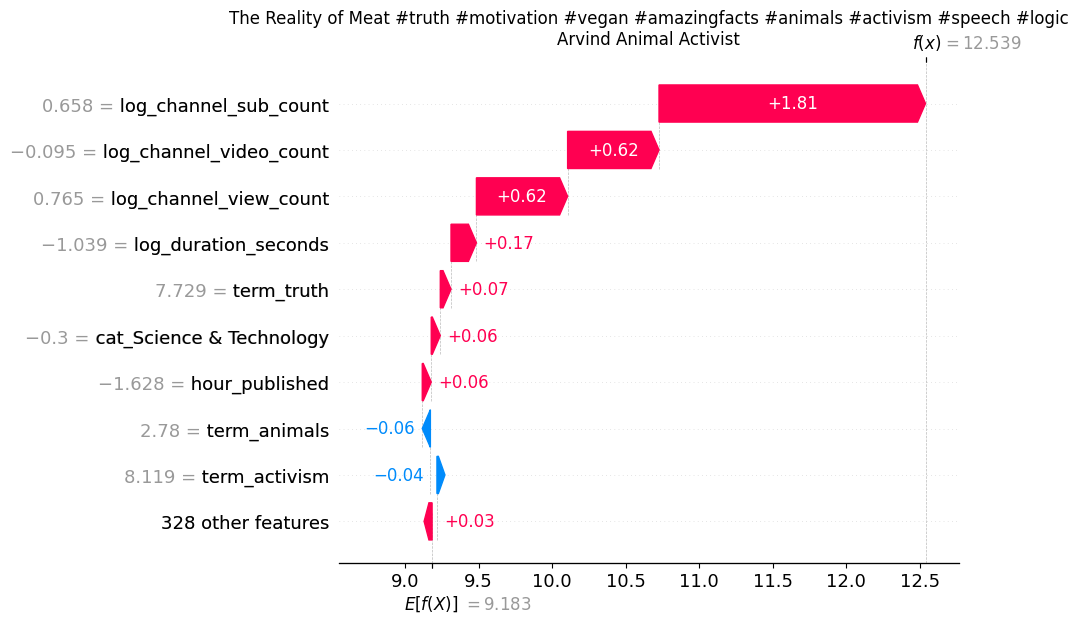

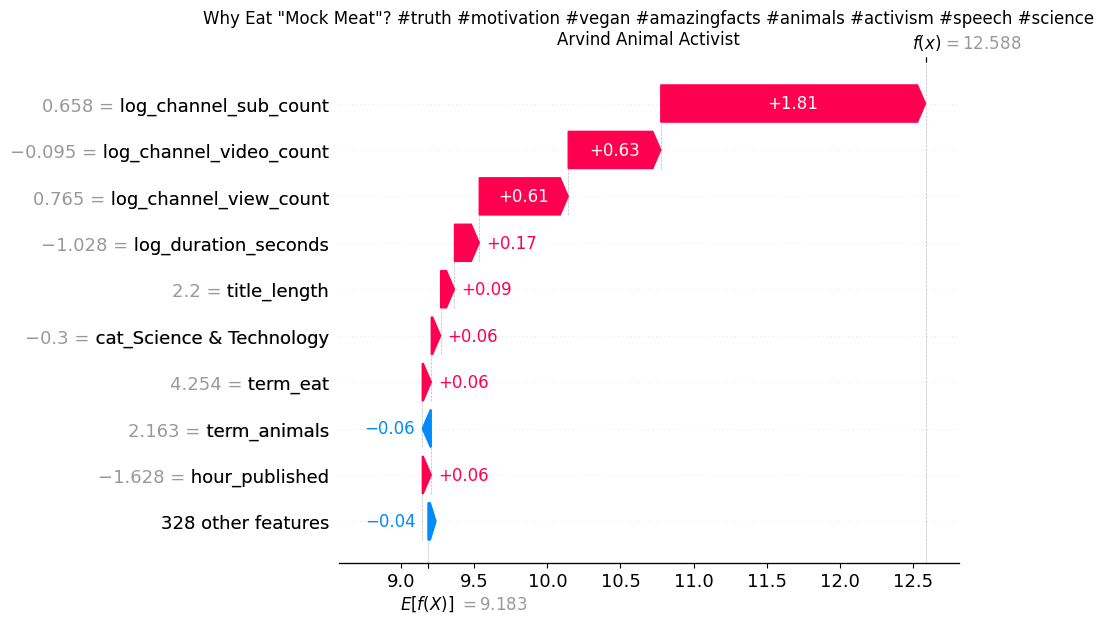

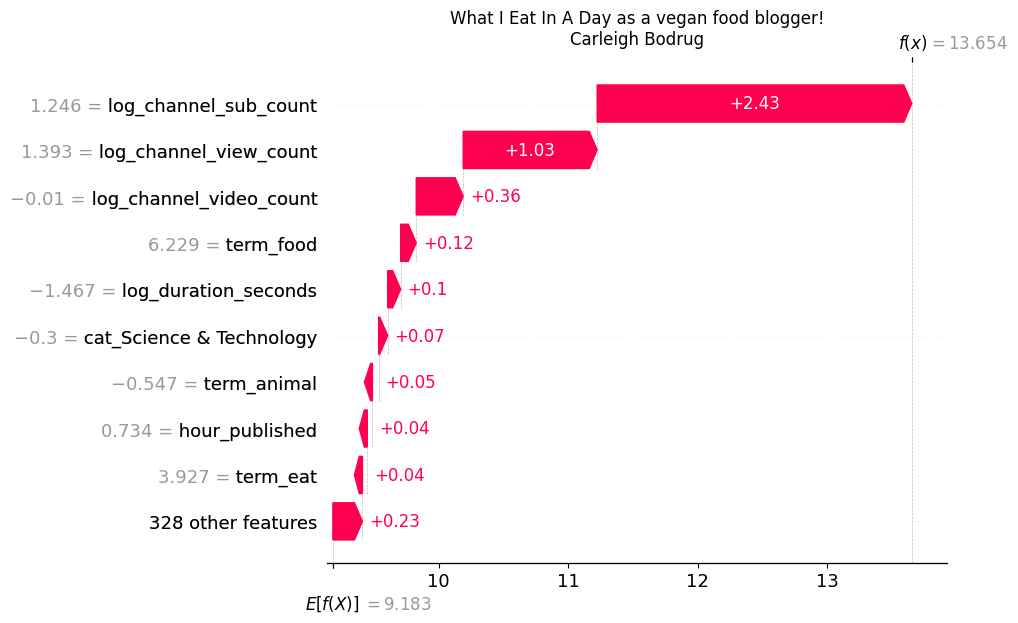

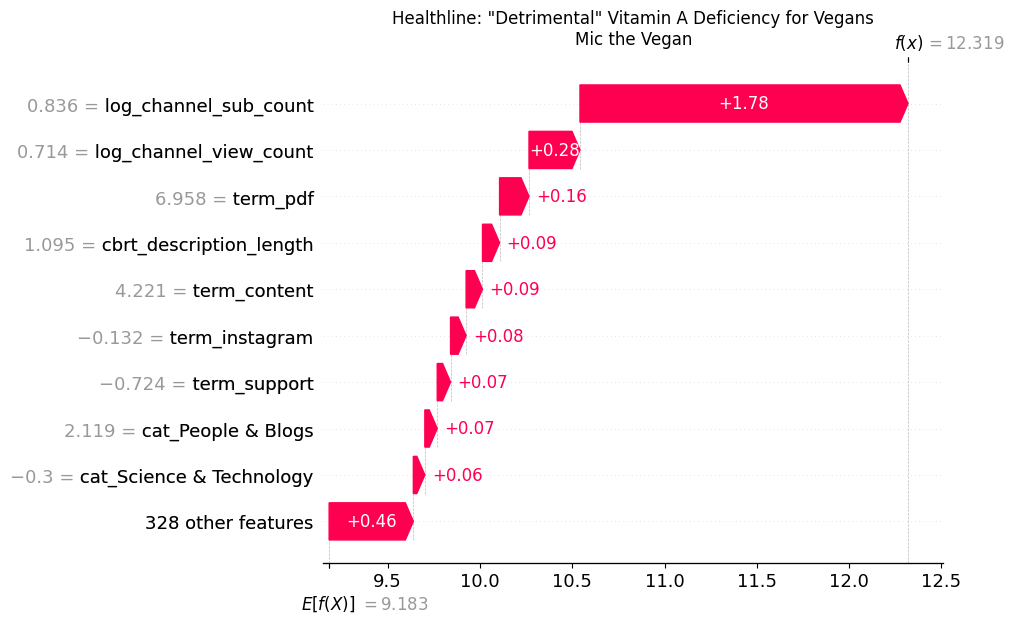

In [8]:
# visualize local shap for top 5 residuals
for i in labled_residuals_negative.index:
    title = labled_residuals.loc[i]["title"] if i != 389 else labled_residuals.loc[i]["title"][:44]
    plt.title(f"{title}\n{labled_residuals.loc[i]["channel_title"]}", y=1.02)
    shap.waterfall_plot(shap.Explanation(values=shap_values.loc[i].values, base_values=explainer.expected_value, data=X_test_scaled.loc[i].values, feature_names=X_test_scaled.columns), show=False)
    file = ("_").join(labled_residuals.loc[i]["channel_title"].lower().split(" "))

    # save png
    plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [9]:
# sort residuals by highest predictions
highest_predicted = labled_residuals.sort_values("act_predicted", ascending=False).head()
highest_predicted

,video_id,title,channel_title,log_view_count,log_predicted,log_residual,act_view_count,act_predicted,act_residual
119,3g-KqNqFA9Y,"Forget hummus, make this instead",Rainbow Plant Life,14.807298,14.011680,0.795618,2696047.0,1216731.47,1479315.53
389,Uw2FbUawACQ,What I Eat In A Day as a vegan food blogger! 🌮...,Carleigh Bodrug,13.436627,13.654472,-0.217845,684624.0,851258.14,-166634.14
472,bi1cfkksehM,Think From The Victim's Perspective #vegan #an...,Arvind Animal Activist,13.733994,12.717965,1.016029,921716.0,333688.10,588027.90
460,HoPGzB0NMuA,Major Update! #vegan #animals #update #speaker...,Arvind Animal Activist,10.458120,12.690944,-2.232824,34825.0,324792.09,-289967.09
354,STWUAUFsyKQ,"Why Eat ""Mock Meat""? #truth #motivation #vegan...",Arvind Animal Activist,10.819978,12.587756,-1.767778,50009.0,292948.66,-242939.66


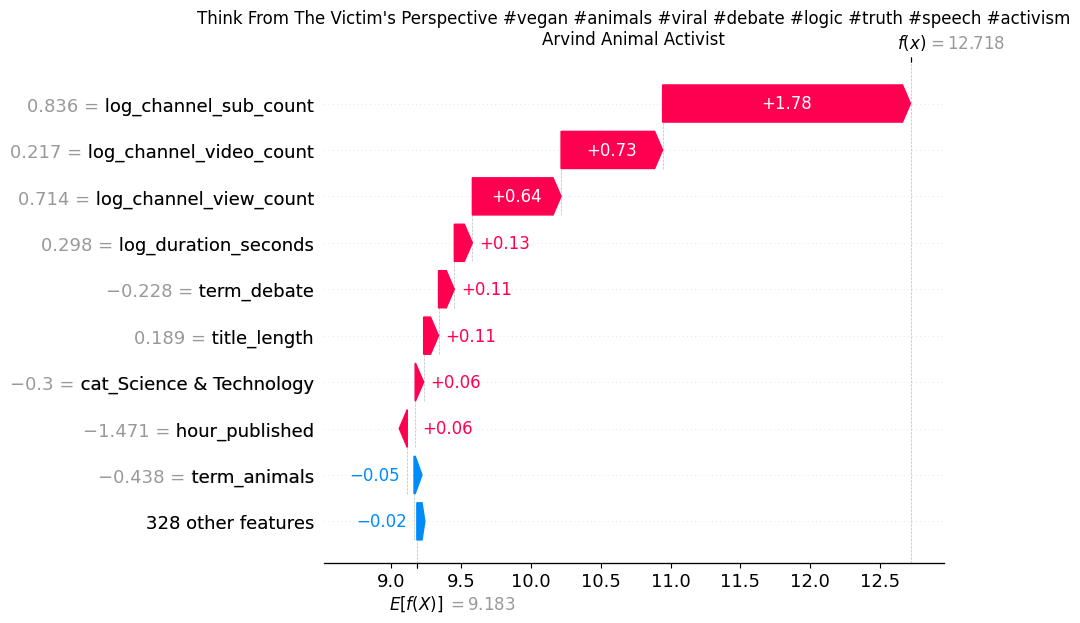

In [10]:
# visualize local shap for highest predictions
plt.title(f"{labled_residuals.loc[472]["title"]}\n{labled_residuals.loc[472]["channel_title"]}", y=1.02)
shap.waterfall_plot(shap.Explanation(values=shap_values.loc[472].values, base_values=explainer.expected_value, data=X_test_scaled.loc[i].values, feature_names=X_test_scaled.columns), show=False)
file = ("_").join(labled_residuals.loc[472]["channel_title"].lower().split(" "))

# save png
plt.savefig(f"images/local_shap/{file}_472.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
# Get the top viewed outreach videos
outreach_residuals = pd.merge(labled_residuals, X_test["term_outreach"], left_index=True, right_index=True)[X_test["term_outreach"] > 0]
top_view_outreach = outreach_residuals.sort_values("act_view_count", ascending=False)
top_view_outreach.head()

/tmp/ipykernel_4527/3680254720.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outreach_residuals = pd.merge(labled_residuals, X_test["term_outreach"], left_index=True, right_index=True)[X_test["term_outreach"] > 0]


,video_id,title,channel_title,log_view_count,log_predicted,log_residual,act_view_count,act_predicted,act_residual,term_outreach
485,B8JS_dFjRgw,10 Weeks to Vegan | Vegan Outreach,Vegan Outreach,9.171080,6.728338,2.442741,9614.0,834.76,8779.24,0.354998
671,YPPmX7MShTU,THE BEST CONVERSATION ...so far! PEACEFUL Veg...,James Kite,8.395929,7.062672,1.333257,4428.0,1166.56,3261.44,0.302863
464,lJE1YYYVTT0,Animal-Lover Shocked by the TRUTH!!! PEACEFUL ...,James Kite,8.134761,7.176883,0.957878,3410.0,1307.82,2102.18,0.153850
380,cU2yNuDb1gk,VEGAN OUTREACH MADE EASY - Clif Grant on the S...,Clif Grant,7.562162,7.588954,-0.026792,1923.0,1975.25,-52.25,0.084131
683,zThQB4y0Q6g,HOW MANY Animals Are Killed Every Year... and ...,The Cranky Vegan,6.855409,7.878257,-1.022848,948.0,2638.27,-1690.27,0.177629


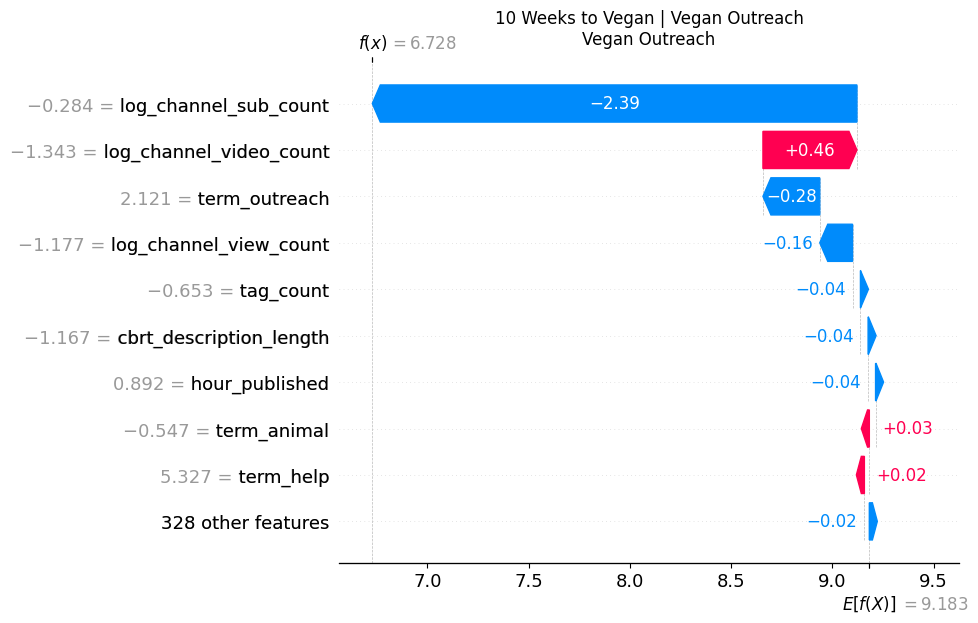

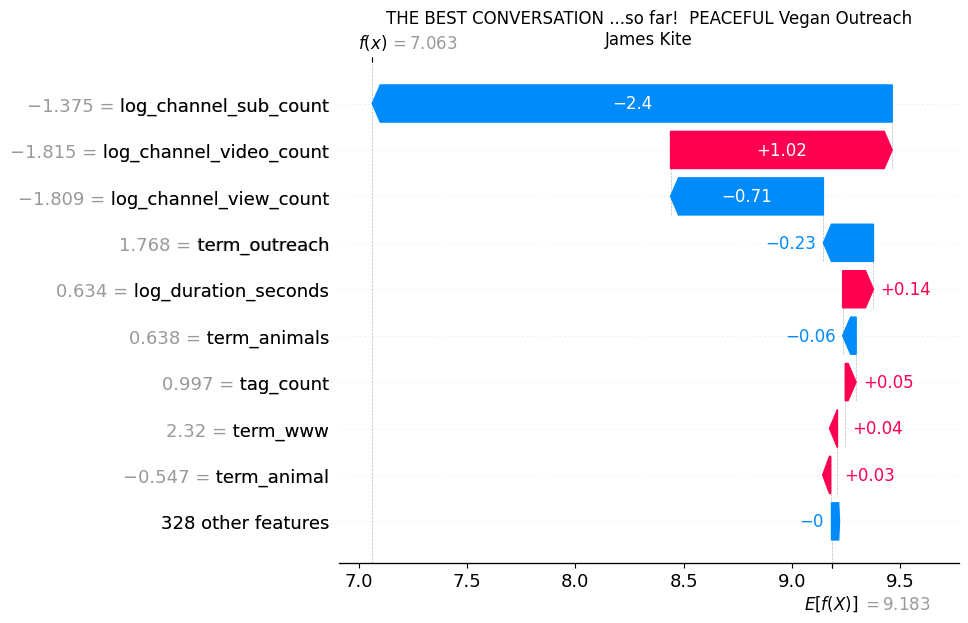

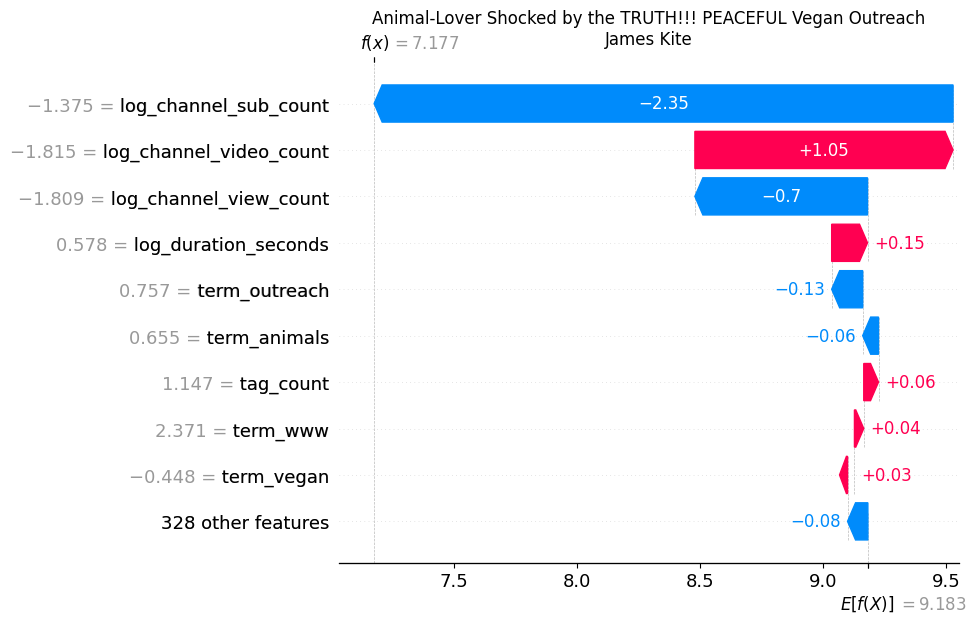

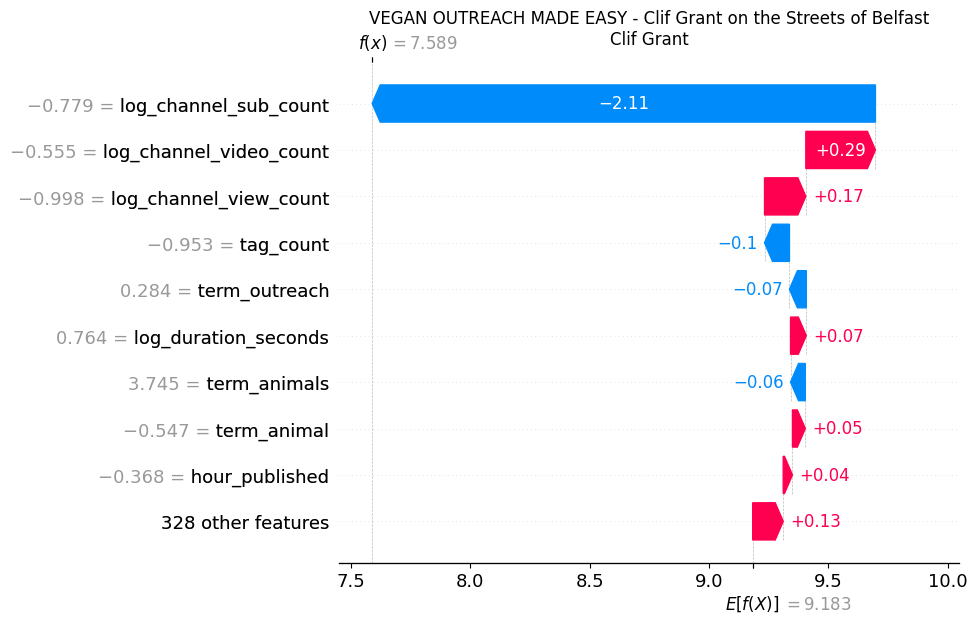

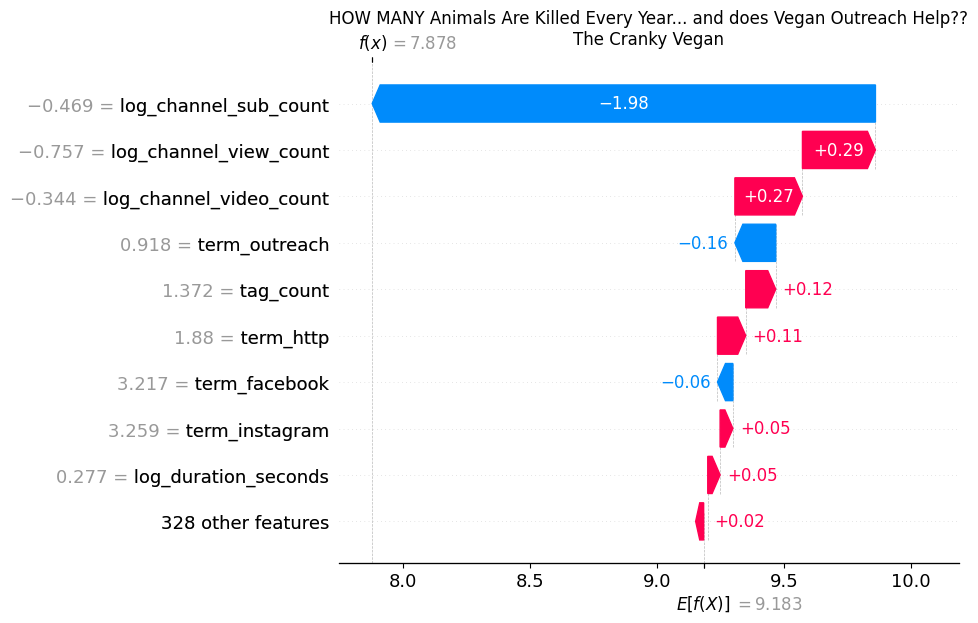

In [12]:
# visualize local shap for top 5 outreach videos
for i in top_view_outreach.index[:5]:
    plt.title(f"{top_view_outreach.loc[i]["title"]}\n{top_view_outreach.loc[i]["channel_title"]}", y=1.02)
    shap.waterfall_plot(shap.Explanation(values=shap_values.loc[i].values, base_values=explainer.expected_value, data=X_test_scaled.loc[i].values, feature_names=X_test_scaled.columns), show=False)
    file = ("_").join(top_view_outreach.loc[i]["channel_title"].lower().split(" "))

    # save png
    plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [13]:
# Get the least viewed music videos
music_residuals = pd.merge(labled_residuals, X_test["cat_Music"], left_index=True, right_index=True)[X_test["cat_Music"] == 1]
least_view_music = music_residuals.sort_values("act_view_count")
least_view_music

/tmp/ipykernel_4527/2435392257.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  music_residuals = pd.merge(labled_residuals, X_test["cat_Music"], left_index=True, right_index=True)[X_test["cat_Music"] == 1]


,video_id,title,channel_title,log_view_count,log_predicted,log_residual,act_view_count,act_predicted,act_residual,cat_Music
647,sq3HmDyfRKE,Animal Liberation Music 🎵 For The Voiceless,The Green Note 🌱🎵,3.784190,6.688386,-2.904196,43.0,802.02,-759.02,1
207,kOrNI6p-NaY,Mob 47 - Animal Liberation/Vi Kan (1987 Rehear...,禅,7.148346,7.732387,-0.584042,1271.0,2280.04,-1009.04,1


/tmp/ipykernel_4527/3167574109.py:9: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


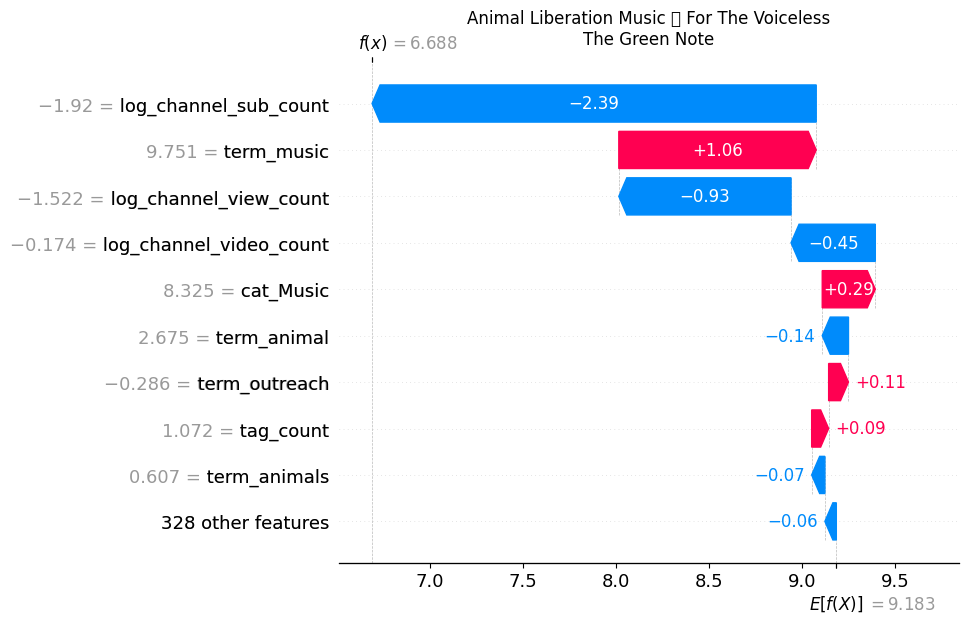

/tmp/ipykernel_4527/3167574109.py:9: UserWarning: Glyph 31109 (\N{CJK UNIFIED IDEOGRAPH-7985}) missing from font(s) DejaVu Sans.
  plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31109 (\N{CJK UNIFIED IDEOGRAPH-7985}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


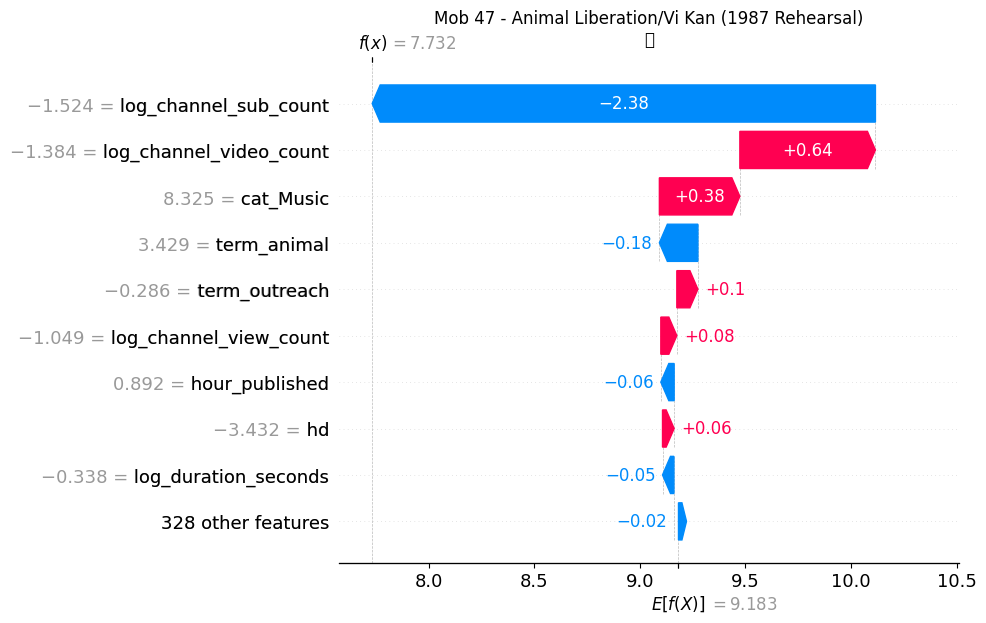

In [14]:
# visualize local shap for music videos
for i in least_view_music.index:
    channel = least_view_music.loc[i]["channel_title"][:14] if i == 647 else least_view_music.loc[i]["channel_title"]
    plt.title(f"{least_view_music.loc[i]["title"]}\n{channel}", y=1.02)
    shap.waterfall_plot(shap.Explanation(values=shap_values.loc[i].values, base_values=explainer.expected_value, data=X_test_scaled.loc[i].values, feature_names=X_test_scaled.columns), show=False)
    file = ("_").join(channel.lower().split(" "))

    # save png
    plt.savefig(f"images/local_shap/{file}_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [21]:
np.expm1(6.688386 -1.06 - 0.29)

np.float64(207.1764422160229)